In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### DISCLAIMER

This annex notebook is provided as it was during the proposal capstone project.
Initially, there was two parts but as discussed during 1:1, the second part has been abandoned. So, all the sections/explanation concerning the transit models can be skipped because the transit models are not used at all during the capstone project.

# Overview of the Data Validation Time-Series FITS Files

Within the Kepler pipeline, stars that have been identified with at least one Threshold-Crossing Event, a serie of at least three transit-like signals with a consistent period and sufficient signal-to-noise ratio, are put through a process called Data Validation (DV). DV produces several data products including the DV FITS files.

There is one FITS file per target star. Each file stores the following data :
* Information about the conditions of experimentation
* The stellar properties of the target star
* For each recorded TCE:
    * The transit parameters and TCE information
    * Many time-series including the transit model and the folded light curve from which it has been fitted
    * Statistics about the TCE
* Statistics time-series justifying the discovery of the transits and their extracted signals

The goals of this notebook are :

1. Exploring how FITS files are structured:
    * Extracting the stellar properties from the primary header
    * Extracting data from the statistics extension
    * Extracting the TCE transit parameters from the extension headers
    * Extracting the TCE transit models and folded light curves from the extension data
2. Preparing and normalizing the transit models
4. Presenting the stellar properties and transit parameters dataset that will be used in part 1
5. Presenting the transit models dataset that will be used in part 2
6. Building a simple model using the transit models as a proof of concept

The K00752.01 TCE data (Kepler-227b confirmed exoplanet) are used for demonstration purposes.

**Related Links:**

Download the FITS files:  
https://archive.stsci.edu/missions/kepler/dv_files/tar_files_dr25/  

FITS File format documentation:  
https://exoplanetarchive.ipac.caltech.edu/docs/DVTimeSeries-Description.pdf

exo.MAST portal for easy visualization:  
https://exo.mast.stsci.edu

# 1. The FITS files structure and data extraction 

In [2]:
# The astropy library is required to manipulate FITS files
from astropy.io import fits

In [3]:
# The K00752.01 transit model data are stored in a FIT file with the KIC host star number in its name
filepath = '../resources/source_data/kplr010797460-20160128150956_dvt.fits'

The filename is composed with the Kepler Input Catalog number KIC of the host star, here 010797460 and the export date of the data validation report.  
This KIC number corresponds to the `kepid` columns in the KOIs Activity Table (padded with 0 on nine digits).    

## The FITS file structure

In [4]:
# Print FITS structure information
fits.info(filepath)    

Filename: ../resources/source_data/kplr010797460-20160128150956_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  TCE_1         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  TCE_2         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  3  Statistics    1 BinTableHDU    221   71427R x 50C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


FITS files are composed of a primary header and many extensions with also their own header. The primary header is  used to store information global to the file, extension headers contains information specific to the extension.

Here we can see that the FITS File contains three extensions. The presence of the TCE_1 and TCE_2 extensions means that there are two registred TCEs associated with the host star (KIC 010797460), so potentially two exoplanet candidates (both are the confirmed exoplanet Kepler-227b and Kepler 227c respectively). 

The transit parameters and the transit model for the K00752.01 TCE are stored in the TCE_1 extension. The TCE_2 extension stores the K00752.02 TCE data. The TCE extension is given by the KOI number decimal part.

We can see that each extension contain many "arrays" of 71'427 point each (70 in total) that explains the size of the file and the huge volume of data downloaded to prepare the datasets. 

## Extracting stellar properties from the primary header

The primary header stores the stellar properties of the host star and information about the conditions of experimentation :

In [5]:
# Get the primary header
fits.getheader(filepath, ext=0)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    4 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2016-03-01'         / file creation date.                            
CREATOR = '1165179 DvTimeSeriesExporter2PipelineModule' / pipeline job and progr
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.43 r61051' / SW version   
FILEVER = '2.0     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In summary, we can see that the primary header provides the following data about the hosting star:

* Effective temperature
* Surface gravity
* Metallicity
* Radius
* Spectral band magnitudes
* Reddening
* Extinction

These data can easely be extracted :

In [6]:
# Extract some stellar parameters from the primary header: 
with fits.open(filepath, mode='readonly') as hdulist:
    star_teff = hdulist[0].header['TEFF']    # Effective temperature
    star_logg = hdulist[0].header['LOGG']    # Surface gravity
    star_tmag = hdulist[0].header['KEPMAG']  # Kepler magnitude
    
print('Star effective temperature: {:.6f} K'.format(star_teff))
print('Star log10 surface gravity: {:.6f}'.format(star_logg))
print('Star Kepler magnitude: {:.6f}'.format(star_tmag))

Star effective temperature: 5850.000000 K
Star log10 surface gravity: 4.426000
Star Kepler magnitude: 15.347000


## Extracting data from the statistics extension

The statistics extension contains statistics and time-series generated at different stages of the Kepler processing data pipeline. They are out the scope of this project. However, it's interesting to plot the PDCSAP_FLUX that is the source signal that will be processed and searched for TCE by the TPS (transit planet search) and DV (data validation) pipeline modules.

In [7]:
# Get the statistics header
fits.getheader(filepath, ext=3)

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  204 / length of first array dimension                
NAXIS2  =                71427 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   50 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [8]:
# Get the statistics data
fits.getdata(filepath, ext=3).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'RESIDUAL_LC'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'DEWEIGHTS'; format = 'E'; unit = 'proportion'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B24.24'
    name = 'SES_CORR_1_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_4_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_5_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_6_0'; format = 'E'; disp = 'E14.7'
    nam

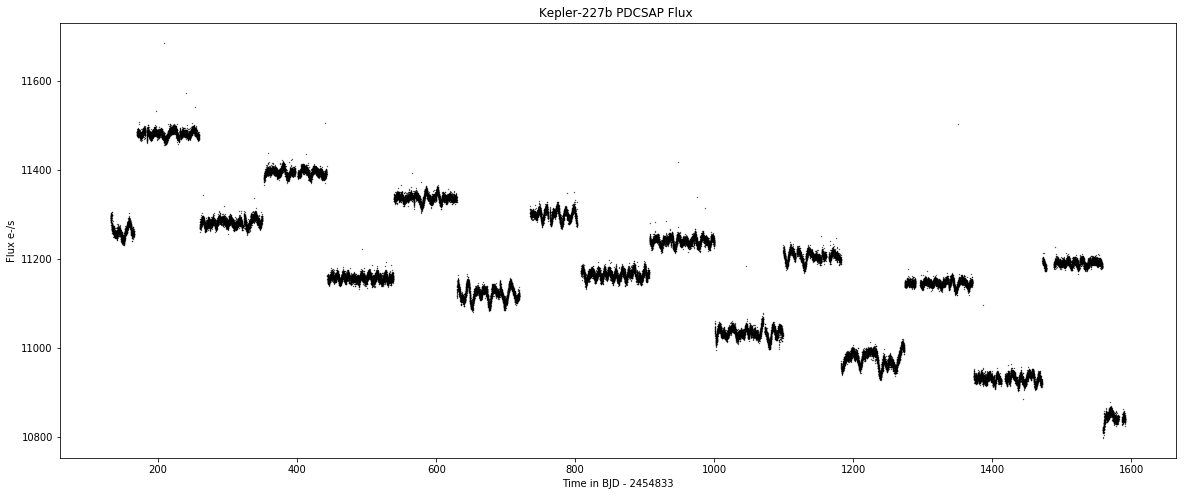

In [9]:
# Extract the time and pdcsap flux from the statistics extension data
with fits.open(filepath, mode='readonly') as hdulist:
    time = hdulist[3].data['TIME']
    flux = hdulist[3].data['PDCSAP_FLUX']
    
# Plot the pdcsap flux
plt.figure(figsize=(20,8))
plt.plot(time, flux, 'ko', markersize=0.3, label='detrended fluxes')
plt.title('Kepler-227b PDCSAP Flux ')
plt.xlabel("Time in BJD - 2454833")
plt.ylabel("Flux e-/s")
plt.show()

This plot shows the brightness of the Kepler-227b's host star during the four and half year of the Kepler Telescope lifespan. Each quarter, the Kepler Telescope needed to be reoriented to receive energy from the sun and its solar pannels. It is the cause of the discontinuities in this signal, each part corresponding to one of the 17 quarters. The transit models used in this project are in fact extracted from this source signal.

## Extracting the TCE transit parameters from the TCE extension header

The TCE extension header stores the transit parameters, some statistics and TCE information:

In [10]:
# Get the TCE_1 extension header
fits.getheader(filepath, ext=1)

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   44 / length of first array dimension                
NAXIS2  =                71427 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   10 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In summary, we can see that the TCE header provides the following data about the transit:

* Period
* Duration
* Ingress duration
* Depth
* Planet radius in earth radii
* Ratio of planet distance to star radius
* Ratio of planet raidus to star radius

and some statistics that could be usefull for data cleaning purposes:

* Signal to noise ratio
* Maximum multi-event statistic
* Maximum single-event statistic
* Converge flag

These data can easely be extracted :

In [11]:
# Extract some transit information from the first TCE extension header: 
with fits.open(filepath, mode='readonly') as hdulist:
    period = hdulist[1].header['TPERIOD']  # Transit period in days
    duration = hdulist[1].header['TDUR']   # Transit duration in hours
    depth = hdulist[1].header['TDEPTH']    # Transit depth in ppm
    
print("Period: {:.6f} days".format(period))
print("Duration: {:.6f} hours".format(duration))
print("Depth: {:.6f} ppm".format(depth))

Period: 9.488028 days
Duration: 3.418783 hours
Depth: 630.381630 ppm


## Extracting the TCE transit model from the TCE extension data structure 

The transit model is stored in the TCE extension data structure :

In [12]:
# Get the data summary from the first TCE extension
fits.getdata(filepath, ext=1).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PHASE'; format = 'E'; unit = 'days'; disp = 'E14.7'
    name = 'LC_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_INIT_ERR'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_DETREND'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
)

The relative brightness of the folded light curve and its corresponding transit model are stored respectively in the LC_INIT and MODEL_INIT vectors. Folded light curves and transit models are defined by their phase stored in the PHASE vector. Note that the LC_INIT and MODEL_INIT vectors must be sorted along the PHASE vector to be plotted because they are sorted along the TIME vector by default. 

Here is how to extract and plot the TCE folded light curve and the fitted transit model :

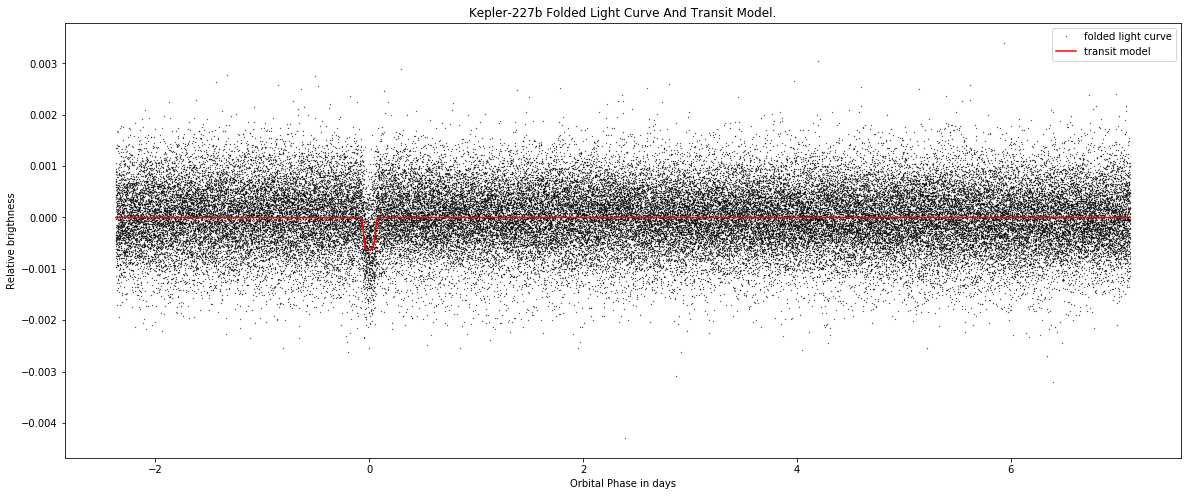

In [13]:
# Extract the phase, light curve and transit model from the first TCE extension  
with fits.open(filepath, mode='readonly') as hdulist:
    phase = hdulist[1].data['PHASE']
    lc_flux = hdulist[1].data['LC_INIT']
    model_flux = hdulist[1].data['MODEL_INIT']
    
    # Sort the transit model and light curve vectors by phase
    sort_indices = np.argsort(phase)
    phase = phase[sort_indices]
    lc_flux = lc_flux[sort_indices]
    model_flux = model_flux[sort_indices]

# Plot the folded light curve and transit model
plt.figure(figsize=(20,8))
plt.plot(phase, lc_flux, 'ko', markersize=0.3, label='folded light curve')
plt.plot(phase, model_flux, '-r', label='transit model')
plt.title('Kepler-227b Folded Light Curve And Transit Model.')
plt.xlabel("Orbital Phase in days")
plt.ylabel("Relative brigthness")
plt.legend()
plt.show()

The folded light curve and transit model are plotted on one full transit period from $-\frac{1}{4}P$ to $\frac{3}{4}P$ where $P$ is the transit period.  
The transit is always centered at $Phase = 0$. 

Transit models are our features in the part 2 of the project. However they can't be used as is and need some preparation...

# 2. Preparing and normalizing the transit models

Transits have all different period, duration and depth (brigthness dimming). Normalization of the transit models is a required preprocessing step to the training of deep learning and random forest models, two kinds of model that we will build. Moreover, transit models are vectors of more than 70'000 data points that is too huge, with most of them being data points with 0 brigthness intensity value, not very usefull.

In [14]:
# Print the transit model length
print('Transit model length:', model_flux.shape[0])

# Print the number of missing values
print('Transit model number of NaN values:', np.isnan(model_flux).sum())

# Print the proportion of 0 values 
print('Transit model proportion of 0 values: {:.2f}'.format((model_flux == 0).sum() / model_flux.shape[0]))

Transit model length: 71427
Transit model number of NaN values: 0
Transit model proportion of 0 values: 0.98


It's also important to note that the phase discretization step is not constant :

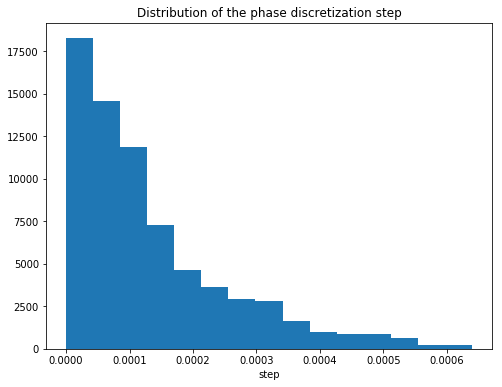

In [15]:
# Plot the distribution of the phase discretization step
steps = phase[1:] - phase[0:-1]

plt.figure(figsize=(8, 6))
plt.hist(steps, bins=15)
plt.xlabel('step')
plt.title('Distribution of the phase discretization step')
plt.show()

Our preparation and normalization of the transit models must satisify the following conditions:

1. Have a reasonable length
2. Have a constant discretization step
3. The transits must be centered in the vector
4. The transits must occupy the same width in the vector
5. The transits minimum intensities are normalized to -1

To respond to these constraints, the transit models will be prepared as described below:

1. The vector length is choosen to be N = 400
2. These N = 400 *data points* are bins resulting from the binarization of the transit model. Each bin will be attributed the median value of the transit model values falling in the corresponding bin/phase range
3. The N bins corresponds to a phase range spanning from $-\frac{1}{2}kD$ to $\frac{1}{2}kD$ where D is the transit duration and k the number of durations (k = 2). This rule ensure that transits are centered and occupy the same width in the vector
4. The bin values are normalized to -1 by dividing them by the absolute value of the minimum value in the vector

Because the variable phase discretization step, it is possible to generate missing values during the binarization process depending the choosen number of bins and the TCE transit period. These potential missing values are replaced by the nearest backward neighbor (fill value forward).

Here are functions that allow to prepare and normalize transit models:

In [16]:
# Function that return all the required data for specific TCE in .fits file
def tce_data(filepath, tce_number=1):
    # extract data from the fits file
    with fits.open(filepath, mode="readonly") as hdulist:
        tce = {}
        
        # IDs
        tce['KEPLERID']  = filepath.split('-')[0][-9:]
        tce['TCENUMBER'] = tce_number
            
        # TCE information
        for key in ['TPERIOD', 'TDUR', 'TDEPTH']:
            tce[key] = hdulist[tce_number].header[key]

        # TCE data
        for key in ['PHASE', 'MODEL_INIT', 'LC_INIT']:
            data = hdulist[tce_number].data[key]
            if key == 'PHASE':
                 sort_indices = np.argsort(data)
            
            tce[key] = data[sort_indices]
        
    return tce


# Function that return a normalized transit model vector
# The transit is centered, the vector has a length of n_bins equivalent to n_duration transit duration
def tce_normalized(tce, flux='MODEL_INIT', n_duration=2, n_bins=400):
    
    # get the transit data
    duration = tce['TDUR'] / 24  # in days
    phase = tce['PHASE']
    data = tce[flux]
    
    # create the bins 
    phase_start = -0.5 * n_duration * duration
    phase_end = 0.5 * n_duration * duration
    bins = np.linspace(phase_start, phase_end, n_bins + 1)

    # digitalize the model by computing the median of each bin
    binned_data = []
    for i in range(0, len(bins) - 1):
        idx = (phase >= bins[i]) & (phase < bins[i+1])
        if idx.sum() > 0:
            median_value = np.median(data[idx])
        else:
            # missing value generated by the binarization process
            median_value = np.NaN
        binned_data.append(median_value)    
    
    # create a dateframe 
    df = pd.DataFrame(binned_data)
    
    # handle missing value with fill forward
    df.ffill(inplace=True)
    if df.isnull().values.any():
        # handle remaining missing value with fill backward (possible left border missing values)
        df.bfill(inplace=True)
    
    # back to ndarrays
    binned_data = df.values
        
    # standardization (transit depth = -1)
    binned_data = binned_data / np.abs(np.min(binned_data))
    
    # store the digitized model
    tce[flux + '_BINNED'] = binned_data
    return tce


# Function that plot a normalized curve
def tce_normalized_plot(tce, flux='MODEL_INIT', figsize=(8, 8)):
    plt.figure(figsize=figsize)
    plt.plot(tce[flux + '_BINNED'], label='model fluxes')
    plt.xlabel('Bin Number')
    plt.ylabel("Normalized Brightness")
    plt.title('KIC {} TCE {} - Normalized Transit Model.'.format(tce['KEPLERID'], tce['TCENUMBER']))

We can use these functions to prepare the Kepler-227b transit model:

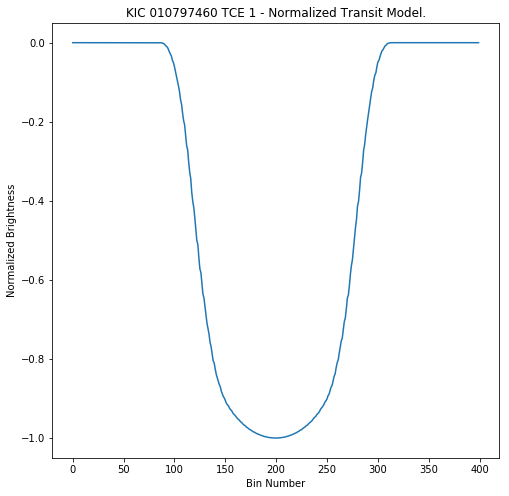

In [17]:
# Get TCE data from the FITS file
tce = tce_data(filepath, tce_number=1)

# Get the binarized and standardized curve
# vector length: 400
# n transit duration: 2
tce = tce_normalized(tce, flux='MODEL_INIT', n_duration=2, n_bins=400)

# Plot the normalized transit model
tce_normalized_plot(tce, flux='MODEL_INIT')

As expected, the transit model curve is now two transit durations long represented by 400 bins with the transit centered and a transit depth normalized to -1.  
The transit occupy half of the vector length. This kind of U shape curve is often the signature of an exoplanet transit, other phenomena having V shape curves.

# 3. The stellar properties and transit parameters dataset

The following dataset has been generated by the `2_Datasets_Preparation.ipynb notebook`.
All the data have been extrated from the FITS files as demonstrated in the section 1.

Here is a sample of the full dataset:

In [18]:
# Load the dataset
filename = '../resources/prepared_data/stellar_properties_and_transit_parameters.csv'
df = pd.read_csv(filename, index_col=[0])

print('Shape:', df.shape)
df.head()

Shape: (7732, 99)


,kepoi_name,koi_disposition,kepid,filename,origin,date,creator,procver,filever,timversn,...,impact,inclin,drratio,radratio,pradius,maxmes,maxses,ntrans,convrge,meddetr
0,K00752.01,CONFIRMED,10797460,kplr010797460-20160128150956_dvt.fits,NASA/Ames,2016-03-01,1165179 DvTimeSeriesExporter2PipelineModule,svn+ssh://murzim/repo/soc/tags/release/9.3.43 ...,2.0,OGIP/93-003,...,0.934177,84.169681,9.196221,0.028956,2.929099,28.470819,5.135849,142,True,17.639999
1,K00752.02,CONFIRMED,10797460,kplr010797460-20160128150956_dvt.fits,NASA/Ames,2016-03-01,1165179 DvTimeSeriesExporter2PipelineModule,svn+ssh://murzim/repo/soc/tags/release/9.3.43 ...,2.0,OGIP/93-003,...,0.711630,89.395301,67.428761,0.029346,2.968514,20.109507,7.027669,25,True,23.520000
2,K00753.01,CANDIDATE,10811496,kplr010811496-20160128150956_dvt.fits,NASA/Ames,2016-03-01,1165192 DvTimeSeriesExporter2PipelineModule,svn+ssh://murzim/repo/soc/tags/release/9.3.43 ...,2.0,OGIP/93-003,...,0.929919,89.029114,54.880784,0.129501,12.266182,187.449097,37.159767,56,True,9.800000
3,K00754.01,FALSE POSITIVE,10848459,kplr010848459-20160128150956_dvt.fits,NASA/Ames,2016-03-01,1165166 DvTimeSeriesExporter2PipelineModule,svn+ssh://murzim/repo/soc/tags/release/9.3.43 ...,2.0,OGIP/93-003,...,0.933470,74.673384,3.531577,0.108508,9.365962,541.895081,39.066551,621,True,11.760000
4,K00755.01,CONFIRMED,10854555,kplr010854555-20160128150956_dvt.fits,NASA/Ames,2016-03-01,1165185 DvTimeSeriesExporter2PipelineModule,svn+ssh://murzim/repo/soc/tags/release/9.3.43 ...,2.0,OGIP/93-003,...,0.690533,85.604302,9.009601,0.023557,2.688826,33.191898,4.749945,515,True,8.820000


The dataframe contains features other than the stellar properties and transit parameters that we will use to train models. These supplementary features could be usefull during the EDA and data cleaning processes. The descriptions of each feature are written in the primary and TCE extension headers.

Here is a sample of the stellar properties only:

In [31]:
columns = [
    'kepoi_name',
    'koi_disposition',
    'teff',
    'logg',
    'feh',
    'ebminusv',
    'av',
    'radius',
    'grcolor',
    'jkcolor',
    'gkcolor',
    'gmag',
    'rmag',
    'imag',
    'zmag',
    'd51mag',
    'jmag',
    'hmag',
    'kmag',
    'kepmag',
]

df.loc[:5, columns]

,kepoi_name,koi_disposition,teff,logg,feh,ebminusv,av,radius,grcolor,jkcolor,gkcolor,gmag,rmag,imag,zmag,d51mag,jmag,hmag,kmag,kepmag
0,K00752.01,CONFIRMED,5850.0,4.426,0.14,0.142,0.441,1.040,0.620,0.435,2.243,15.890,15.270,15.114,15.006,15.636,14.082,13.750,13.647,15.347
1,K00752.02,CONFIRMED,5850.0,4.426,0.14,0.142,0.441,1.040,0.620,0.435,2.243,15.890,15.270,15.114,15.006,15.636,14.082,13.750,13.647,15.347
2,K00753.01,CANDIDATE,5853.0,4.544,-0.18,0.120,0.373,0.868,0.553,0.427,2.117,15.943,15.390,15.220,15.166,15.733,14.253,13.900,13.826,15.436
3,K00754.01,FALSE POSITIVE,5795.0,4.546,-0.52,0.122,0.378,0.803,0.546,0.518,2.292,16.100,15.554,15.382,15.266,15.895,14.326,13.910,13.808,15.597
4,K00755.01,CONFIRMED,6031.0,4.438,0.07,0.142,0.440,1.046,0.547,0.414,2.064,16.015,15.468,15.292,15.241,15.799,14.365,14.064,13.951,15.509
5,K00756.01,CONFIRMED,6046.0,4.486,-0.08,0.168,0.522,0.972,0.557,0.397,2.103,16.234,15.677,15.492,15.441,16.000,14.528,14.112,14.131,15.714


And a sample of the transit parameters only :

In [20]:
columns = [
    'kepoi_name',
    'koi_disposition',
    'tperiod',
    'tepoch',
    'tdepth',
    'tsnr',
    'tdur',
    'indur',
    'impact',
    'inclin',
    'drratio',
    'radratio',
    'pradius',
    'maxmes',
    'maxses',
    'ntrans',
    'convrge',
    'meddetr'
]

df.loc[:5, columns]

,kepoi_name,koi_disposition,tperiod,tepoch,tdepth,tsnr,tdur,indur,impact,inclin,drratio,radratio,pradius,maxmes,maxses,ntrans,convrge,meddetr
0,K00752.01,CONFIRMED,9.488028,132.588052,630.381630,31.178432,3.418783,0.659365,0.934177,84.169681,9.196221,0.028956,2.929099,28.470819,5.135849,142,True,17.639999
1,K00752.02,CONFIRMED,54.418374,162.513825,893.123959,20.690699,4.585753,0.257789,0.711630,89.395301,67.428761,0.029346,2.968514,20.109507,7.027669,25,True,23.520000
2,K00753.01,CANDIDATE,19.899143,136.051960,10630.409762,181.560364,1.776158,0.888079,0.929919,89.029114,54.880784,0.129501,12.266182,187.449097,37.159767,56,True,9.800000
3,K00754.01,FALSE POSITIVE,1.736955,132.094000,7874.849223,530.372681,2.341290,1.170645,0.933470,74.673384,3.531577,0.108508,9.365962,541.895081,39.066551,621,True,11.760000
4,K00755.01,CONFIRMED,2.525622,133.702506,578.297482,37.310295,1.624692,0.070214,0.690533,85.604302,9.009601,0.023557,2.688826,33.191898,4.749945,515,True,8.820000
5,K00756.01,CONFIRMED,11.094317,137.918172,1505.847304,59.642475,4.621135,0.271908,0.632917,87.597035,15.095555,0.037383,3.965154,55.204865,9.046456,95,True,23.520000


The `koi_disposition` variable comes from the Cumulative Kepler Objects of Interest Activity Table and is the target variable of our future models.  
Here is its distibution:

In [21]:
# Plot the labels count
pd.value_counts(df.koi_disposition)

FALSE POSITIVE    3638
CONFIRMED         2290
CANDIDATE         1804
Name: koi_disposition, dtype: int64

# 4. The transit model dataset 

All the transit models in this dataset has been prepared as explained in the section 2.  
The following dataset has been generated by the `2_Datasets_Preparation.ipynb` notebook.

Here is a sample of its data : 

In [22]:
# Load the datasets stored as a npz files
with np.load('../resources/prepared_data/transit_models_bins400_nduration2.npz') as npz:
    names  = npz['names']
    labels = npz['labels']
    features = npz['features']
    candidates = npz['candidates']
    
print('Features shape:', features.shape)
print('Candidates shape:', candidates.shape)

Features shape: (5928, 400)
Candidates shape: (1804, 400)


In [23]:
# Print label names
print('Label Names:', names.tolist())

Label Names: ['FALSE POSITIVE', 'CONFIRMED']


Labels are encoded as follow: 
* FALSE POSITIVE => 0
* CONFIRMED => 1

In [24]:
# Plot the labels count
pd.value_counts(labels)

0    3638
1    2290
dtype: int64

In [25]:
# Plot the labels distribution
pd.value_counts(labels, normalize=True)

0    0.613698
1    0.386302
dtype: float64

The most frequent baseline is about 60% of false positives.  
This dataset present good proportions to build models.

Let's plot some sample data, exoplanets and false positives :

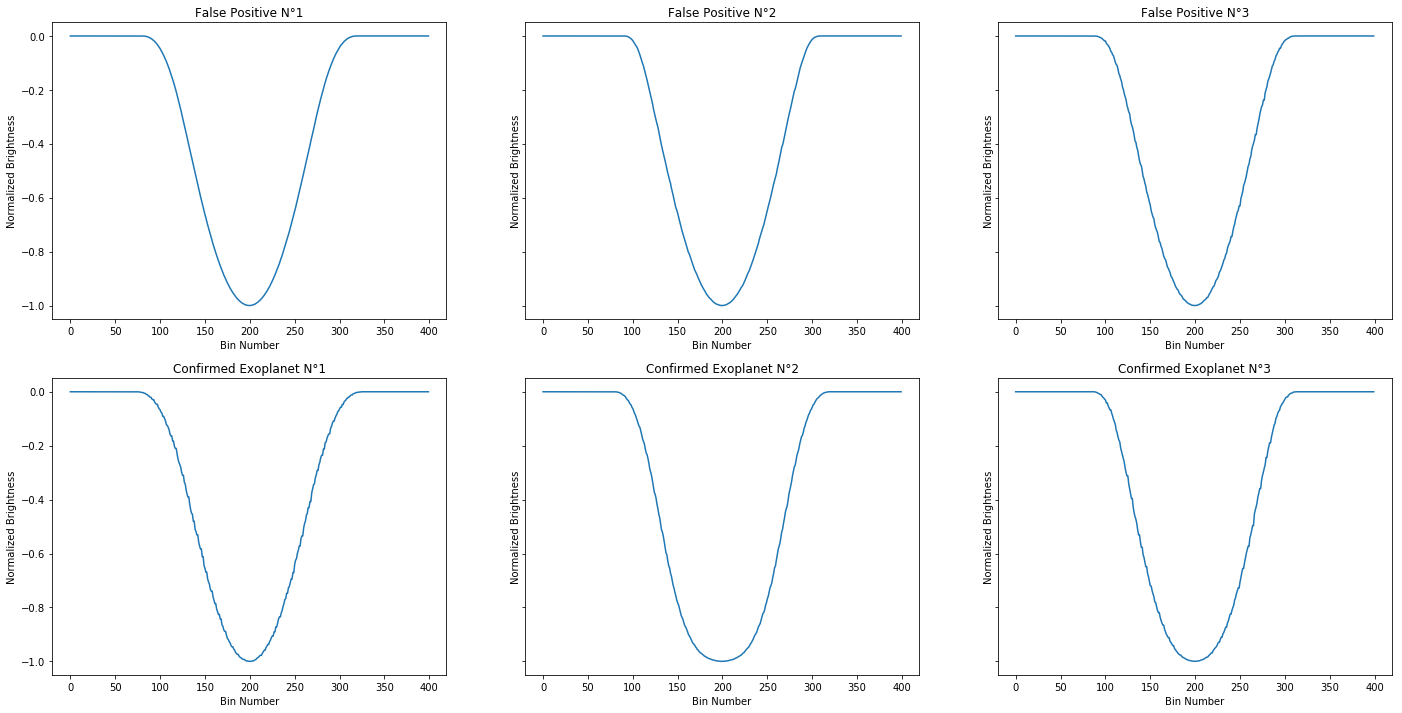

In [26]:
# Plot three confirmed exoplanet and three false positive transit models
false_positives = features[labels == 0][0:3]
confirmed = features[labels == 1][0:3]

fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(24, 12))
for i in range(3):
    ax[0, i].plot(false_positives[i])
    ax[0, i].set_xlabel('Bin Number')
    ax[0, i].set_ylabel('Normalized Brightness')
    ax[0, i].set_title('False Positive N°{}'.format(i+1))
    
for i in range(3):
    ax[1, i].plot(candidates[i])
    ax[1, i].set_xlabel('Bin Number')
    ax[1, i].set_ylabel('Normalized Brightness')
    ax[1, i].set_title('Confirmed Exoplanet N°{}'.format(i+1))

And here the plot of three exoplanet candidates :

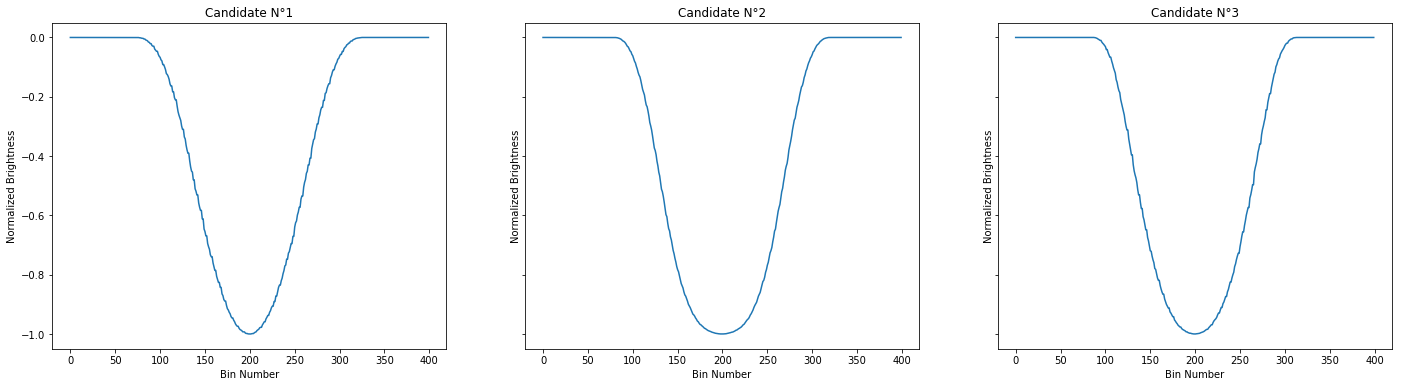

In [27]:
# Plot three exoplanet candidates
candidate_sample = candidates[0:3]

fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(24, 6))
for i in range(3):
    ax[i].plot(candidate_sample[i])
    ax[i].set_xlabel('Bin Number')
    ax[i].set_ylabel('Normalized Brightness')
    ax[i].set_title('Candidate N°{}'.format(i+1))
    

Not so easy to guess, let's see if a decision tree could...

# 5. A decision tree trained with the transit models as a proof of concept

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [29]:
# Split train/test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=600, random_state=0)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (5328, 400)
Test shape: (600, 400)


In [30]:
# Fit a decision tree model
dt = DecisionTreeClassifier(max_depth=3, criterion='gini', random_state=0)
dt.fit(X_train, y_train)

print('Accuracy on train set: ', dt.score(X_train, y_train))
print('Accuracy on test set : ', dt.score(X_test, y_test))

Accuracy on train set:  0.805743243243
Accuracy on test set :  0.79


As we can see, there are some prediction power in the shape of the transit models. This decision tree is already a neat improvement over the baseline model. This sounds promising to identify the strongest exoplanet candidates among the candidates dataset.